In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt

In [2]:
class Directions(enum.Enum):
    Up = 0
    Right = 1
    Down = 2
    Left = 3
    UpRight = 4
    RightDown = 5
    DownLeft = 6
    LeftUp = 7
    
class StateMode(enum.Enum):
    Normal = 0
    Start = -1000
    Final = 1000
    Cliff = -100

class MoveType(enum.Enum):
    Standard = 4
    King = 8


In [3]:
def roulettewheel(policy):
    randNo = np.random.rand()
    roulette = [np.sum(policy[0:i + 1]) for i in range(len(policy))]
    for i in range(len(roulette)):
        if randNo <= roulette[i]:
            return i
#---------------------------------------------------------------------------------------#

def ActionSelection(current_state, policy):
    return roulettewheel(policy[current_state])

#---------------------------------------------------------------------------------------#

def NextState(current_state , action, rowsCount, columnsCount ,start_state):
        
    if action == Directions.Up.value:
        next_state = np.array((current_state[0] - 1, current_state[1]))
    elif action == Directions.Right.value:
        next_state = np.array((current_state[0] , current_state[1] + 1))
    elif action == Directions.Down.value:
        next_state = np.array((current_state[0] + 1, current_state[1]))
    elif action == Directions.Left.value:
        next_state = np.array((current_state[0] , current_state[1] - 1))
    elif action == Directions.UpRight.value:
        next_state = np.array((current_state[0] - 1 , current_state[1] + 1))
    elif action == Directions.RightDown.value:
        next_state = np.array((current_state[0] + 1 , current_state[1] + 1))
    elif action == Directions.DownLeft.value:
        next_state = np.array((current_state[0] + 1 , current_state[1] - 1))
    elif action == Directions.LeftUp.value:
        next_state = np.array((current_state[0] - 1 , current_state[1] - 1))

    if next_state[0] < 0:    #for top
        next_state[0] = 0
    elif next_state[0] > rowsCount - 1:   #for bottomn
        next_state[0] = rowsCount - 1

    if next_state[1] < 0:    #for left
        next_state[1] = 0
    elif next_state[1] > columnsCount - 1:   #for right
        next_state[1] = columnsCount - 1

    return tuple(next_state)
        


In [4]:
def CliffWalking_SARSA(states, numberOfEpisods, alpha, gamma, epsilon, 
                   start_state , terminal_state ,rewards , moveType):

    numberOfRows = len(states)
    numberOfColumns = len(states[0])
    
    episodeSteps = np.zeros(numberOfEpisods)
    
#     Q = np.zeros((numberOfRows, numberOfColumns, moveType.value))
    Q = np.random.rand(numberOfRows, numberOfColumns, moveType.value)
    for i in range(numberOfRows):
        for j in range(numberOfColumns):
            Q[i,j] /= np.sum(Q[i,j])

    policy = np.zeros((numberOfRows, numberOfColumns, moveType.value))

    for i in range(numberOfRows):
        for j in range(numberOfColumns):
            max_index = np.argmax(Q[i,j])
            policy[i,j,:] = epsilon / moveType.value # 1 / moveType.value # epsilon / moveType.value
            policy[i,j,max_index] = 1 - epsilon + (epsilon / moveType.value)

    step_episode_list = []
    episodes = []
    rewards_episode_list = []

    for episodeNo in range(numberOfEpisods):
        
        S = start_state
        # select action based on epsilon-greedy
        A = ActionSelection(S, policy)  
        episode = [(S, Directions(A).name)]
        
        reward_received = 0
        
        while True:
            if states[S] == StateMode.Final.value: # check for final State
                break

            S_prim = NextState(S, A, numberOfRows, numberOfColumns,start_state)
            R = rewards[S_prim]           
            
            reward_received += R

            # select action based on epsilon-greedy *****************************TODO
            A_prim = ActionSelection(S_prim, policy)

            Q[S][A] += alpha * (R + gamma * Q[S_prim][A_prim] - Q[S][A])
            
            # update policy based on epsilon-greedy
            
            max_index = np.argmax(Q[S])
            policy[S][:] =  epsilon / moveType.value
            policy[S][max_index] = 1 - epsilon + (epsilon / moveType.value)
            
            if states[S_prim] == StateMode.Cliff.value :    
                S = start_state
                A = ActionSelection(S, policy)
            else:
                S = S_prim
                A = A_prim
            
            episode.append((S, Directions(A).name, R))
            step_episode_list.append(episodeNo + 1)
        
        rewards_episode_list.append(reward_received)
        
        episodes.append(episode.copy())

    return rewards_episode_list


In [7]:
def CliffWalking_QLearning(states, numberOfEpisods, alpha, gamma, epsilon, 
                   start_state , terminal_state ,rewards , moveType):

    numberOfRows = len(states)
    numberOfColumns = len(states[0])
    
    episodeSteps = np.zeros(numberOfEpisods)
    
#     Q = np.zeros((numberOfRows, numberOfColumns, moveType.value))
    Q = np.random.rand(numberOfRows, numberOfColumns, moveType.value)
    for i in range(numberOfRows):
        for j in range(numberOfColumns):
            Q[i,j] /= np.sum(Q[i,j])
            
    policy = np.zeros((numberOfRows, numberOfColumns, moveType.value))

    for i in range(numberOfRows):
        for j in range(numberOfColumns):
            max_index = np.argmax(Q[i,j])
            policy[i,j,:] = epsilon / moveType.value #1 / moveType.value # epsilon / moveType.value
            policy[i,j,max_index] = 1 - epsilon + (epsilon / moveType.value)

    step_episode_list = []
    episodes = []
    rewards_episode_list = []

    for episodeNo in range(numberOfEpisods):
        
        S = start_state

        episode = []
        
        reward_received = 0
        
        while True:
            if states[S] == StateMode.Final.value: # check for final State
                break
            
            A = ActionSelection(S, policy)

            S_prim = NextState(S, A, numberOfRows, numberOfColumns,start_state)
            R = rewards[S_prim]
            
            
            reward_received += R

            max_Q = np.max(Q[S_prim])

            Q[S][A] += alpha * (R + gamma * max_Q - Q[S][A])
            
            # update policy based on epsilon-greedy            
            max_index = np.argmax(Q[S])
            policy[S][:] =  epsilon / moveType.value
            policy[S][max_index] = 1 - epsilon + (epsilon / moveType.value)
            
            if states[S_prim] == StateMode.Cliff.value : 
                S = start_state
            else:
                S = S_prim
            
            episode.append((S, Directions(A).name, R))
            step_episode_list.append(episodeNo + 1)
        
        rewards_episode_list.append(reward_received)
        
        episodes.append(episode.copy())

    return rewards_episode_list


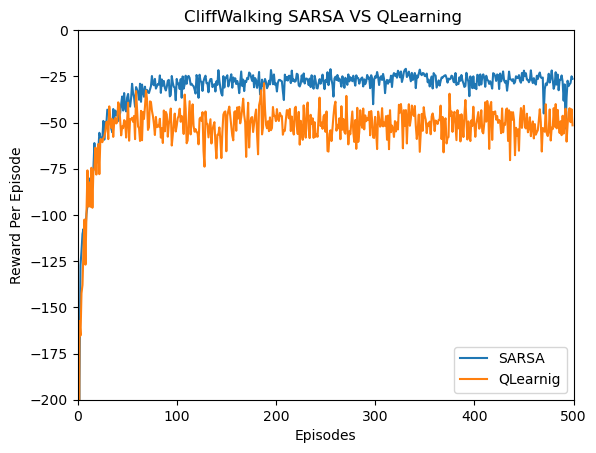

In [11]:
numberOfRows = 4
numberOfColumns = 12
numberOfEpisods = 500
numberOfIterations = 100

alpha = 0.5
gamma = 1
epsilon = 0.1 


states = np.zeros((numberOfRows, numberOfColumns))

start_state = (3, 0)
terminal_state = (3, 11)

states[start_state] = StateMode.Start.value      #1 for Start State
states[terminal_state] = StateMode.Final.value     #2 for Goal State
states[numberOfRows-1 , 1:-1] = StateMode.Cliff.value

rewards = np.zeros((numberOfRows, numberOfColumns))
rewards -=1    #reward is for destination
rewards[numberOfRows-1 , 1:-1] = -100

# print(states)
final_reward_list_SARSA = []
for i in range(numberOfIterations):    
    reward_episode_list =  CliffWalking_SARSA(states, numberOfEpisods, alpha, gamma, epsilon, 
                      start_state , terminal_state ,rewards , MoveType.Standard)
    final_reward_list_SARSA.append(reward_episode_list)


final_reward_list_QLearning = []
for i in range(numberOfIterations):    
    reward_episode_list =  CliffWalking_QLearning(states, numberOfEpisods, alpha, gamma, epsilon, 
                      start_state , terminal_state ,rewards , MoveType.Standard)
    final_reward_list_QLearning.append(reward_episode_list)
    
    
# Plot Results To Output 
plt.plot(np.mean(final_reward_list_SARSA, axis=0), label="SARSA")
plt.plot(np.mean(final_reward_list_QLearning, axis=0), label="QLearnig")
plt.title(f'CliffWalking SARSA VS QLearning ', fontsize = 'large')
plt.xlabel("Episodes")
plt.ylabel("Reward Per Episode")
plt.legend(loc= 'lower right')
plt.axis([0, 500, -200, 0])
plt.show()
